In [306]:
import pymongo
from dotenv import load_dotenv
import os
load_dotenv(os.path.join('./', ".env"))
from pprint import pprint
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', True)
from IPython.display import display

In [307]:
class Client:
    def __init__(self):
        self.client = pymongo.MongoClient(os.environ.get('MONGO_URI_DIRECT'))
        self.db = self.client['production']
        print('MongoDB Connection Established')
    
    def get_mc_data(self):
        self.collection = self.db['co-mc-sales']
        return self.collection.find({},{
            '_id': 0,
            'administration_price': 1,
            'link': 1,
            'age': 1,
            'baths': 1,
            'garages': 1,
            'lat': 1,
            'lng': 1,
            'living_area_m2': 1,
            'neighborhood': 1,
            'price': 1,
            'price_m2': 1,
            'propertyType': 1,
            'rooms': 1,
            'stratum': 1,
            'total_area_m2': 1
        }).sort("_id", -1)
    
    def get_fr_data(self):
        self.collection = self.db['co-fr-sales']
        return self.collection.find({},{
            '_id': 0,
            'administration_price': 1,
            'link': 1,
            'age.name': 1,
            'baths': 1,
            'garages': 1,
            'lat': 1,
            'lng': 1,
            'living_area_m2': 1,
            'neighborhood': 1,
            'price': 1,
            'price_m2': 1,
            'propertyType': 1,
            'rooms': 1,
            'stratum': 1,
            'total_area_m2': 1
        }).sort("_id", -1)
    
mongo = Client()
mc_data = mongo.get_mc_data()
fr_data = mongo.get_fr_data()
mc_df = pd.DataFrame(list(mc_data))
fr_df = pd.DataFrame(list(fr_data))
print('Data imported as DF')

MongoDB Connection Established
Data imported as DF


In [308]:
# Concat all data
main_df = pd.concat([mc_df, fr_df], sort=False)
print('Full df: ', len(main_df.index))
main_df = main_df.drop_duplicates(subset='link')
print('After remove duplicates:', len(main_df.index))
main_df.drop(columns=['link'], inplace=True)
main_df.dropna(subset=['lat', 'lng'], inplace=True)
print('After remove NaN in coordinates: ', len(main_df.index))

# Filter propertyType
main_df = main_df[main_df['propertyType'].isin(['Casa', 'Apartamento', 'Proyecto', 'Apartaestudio'])]
# Filter stratum
main_df = main_df[main_df['stratum'].isin([1,2,3,4,5,6])]
# Filter age
main_df.loc[(main_df['propertyType'] == 'Proyecto') & (main_df['age'].isnull()), 'age'] = 'Entre 0 y 5 años'
main_df['age'] = main_df['age'].values.astype(str)
conditions = [
    main_df['age'].eq('Entre 0 y 5 años') | main_df['age'].eq('Sobre Plano') | main_df['age'].eq('En Construcción') | main_df['age'].eq('Para Estrenar') | main_df['age'].eq("{'name': 'menor a 1 año'}"),
    main_df['age'].eq('Remodelado') | main_df['age'].eq('Entre 5 y 10 años') | main_df['age'].eq("{'name': '1 a 8 años'}"),
    main_df['age'].eq('Entre 10 y 20 años') | main_df['age'].eq("{'name': '9 a 15 años'}"),
    main_df['age'].eq('Más de 20 años') | main_df['age'].eq("{'name': '16 a 30 años'}") | main_df['age'].eq("{'name': 'más de 30 años'}")                                                                                                                                       
]
choices = ['Menor a 5 a#os', 'Entre 5 y 10 a#os', 'Entre 10 y 20 a#os', 'Mas de 20 a#os']                                                                                                                                           
main_df['age'] = np.select(conditions, choices, default=np.NaN)

# Remove nan and empty
main_df.replace('', np.nan, inplace=True)
main_df['age'].replace('nan', np.nan, inplace=True)
main_df['propertyType'].replace('Apartaestudio', 'Apartamento', inplace=True)
main_df.dropna(subset=['garages', 'rooms', 'baths', 'age'], inplace=True)

# Filter administaration_price
main_df = main_df[main_df["administration_price"] >= 0]
# Filter price
main_df = main_df[main_df["price"] > 40000000]
# Filter price_m2
main_df = main_df.loc[(main_df['price_m2'] >= 1000000) & (main_df['price_m2'] <= 12000000)]
# Filter total_area_m2
main_df = main_df.loc[(main_df['total_area_m2'] >= 20) & (main_df['total_area_m2'] <= 400)]
# Filter living_area_m2
main_df = main_df.loc[(main_df['living_area_m2'] >= 20) & (main_df['living_area_m2'] <= 300)]
# Filter baths
#main_df = main_df.loc[(main_df['baths'] < 6) & (main_df['baths'] > 0)]
# Filter garages
#main_df = main_df.loc[(main_df['garages'] < 5)]
# Filter rooms
#main_df = main_df.loc[(main_df['rooms'] < 6)]

main_df = main_df[(main_df['lat'] > 4.58) & (main_df['lat'] < 4.77)]
main_df = main_df[(main_df['lng'] > -74.15) & (main_df['lng'] < -74.02)]

# Encode categorical values
main_df = pd.get_dummies(main_df, columns=["propertyType"])
main_df = pd.get_dummies(main_df, columns=["age"])
main_df.rename(columns={"propertyType_Apartamento": "is_apartment", "age_Menor a 5 a#os": 'is_new', "age_Entre 5 y 10 a#os": 'from_5_to_10_years', "age_Entre 10 y 20 a#os": 'from_10_to_20_years', "age_Mas de 20 a#os": 'More_than_20_years'}, inplace=True)

# Drop features
main_df.drop(columns=['neighborhood','price', 'total_area_m2', 'propertyType_Casa'], inplace=True)

# Normalize prices from millions
main_df['price_m2'] = main_df['price_m2']/1000000
main_df['administration_price'] = main_df['administration_price']/1000000

print('Final DF: ', len(main_df.index))
display(main_df)

Full df:  150775
After remove duplicates: 143662
After remove NaN in coordinates:  143036
Final DF:  82438


,lat,lng,stratum,living_area_m2,administration_price,garages,rooms,baths,price_m2,is_apartment,from_10_to_20_years,from_5_to_10_years,More_than_20_years,is_new
0,4.672921,-74.050480,6.0,136.00,0.000,2.0,2.0,2.0,5.294118,True,False,False,False,True
1,4.653309,-74.051476,6.0,117.51,0.840,2.0,2.0,2.0,9.537037,True,False,True,False,False
2,4.668201,-74.046110,6.0,170.00,1.650,2.0,2.0,3.0,10.294118,True,False,True,False,False
4,4.687755,-74.054930,6.0,71.00,0.442,2.0,1.0,2.0,6.619718,True,False,False,False,True
6,4.680287,-74.056046,6.0,57.00,0.254,1.0,1.0,2.0,7.672727,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69300,4.645190,-74.143356,3.0,48.00,0.000,1.0,3.0,2.0,4.666666,True,False,True,False,False
69301,4.726790,-74.047256,4.0,82.00,0.312,1.0,3.0,2.0,5.121951,True,False,False,True,False
69312,4.704196,-74.052711,5.0,76.00,0.640,2.0,2.0,3.0,5.921052,True,True,False,False,False
69313,4.759000,-74.049004,4.0,84.00,0.200,1.0,3.0,2.0,5.119047,True,True,False,False,False


In [309]:
print(len(main_df.index))

82438


# EDA Analysis

In [298]:
# Import libraries
import seaborn as sns
import matplotlib.pyplot as plt

In [299]:
data = pd.read_csv('Data/Raw_data_sales_full_incl_nbrs.csv')
data.info()
print("Are There Missing Data? :",data.isnull().any().any())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82430 entries, 0 to 82429
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   lat                   82430 non-null  float64
 1   lng                   82430 non-null  float64
 2   stratum               82430 non-null  float64
 3   living_area_m2        82430 non-null  float64
 4   administration_price  82430 non-null  float64
 5   garages               82430 non-null  float64
 6   rooms                 82430 non-null  float64
 7   baths                 82430 non-null  float64
 8   price_m2              82430 non-null  float64
 9   is_apartment          82430 non-null  bool   
 10  from_10_to_20_years   82430 non-null  bool   
 11  from_5_to_10_years    82430 non-null  bool   
 12  More_than_20_years    82430 non-null  bool   
 13  is_new                82430 non-null  bool   
dtypes: bool(5), float64(9)
memory usage: 6.1 MB
Are There Missing Data? : 

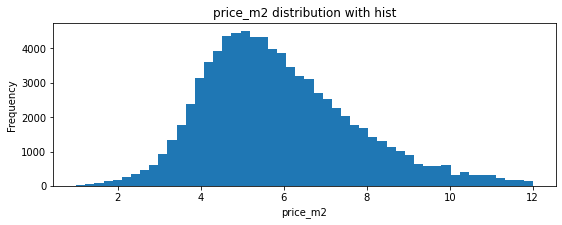

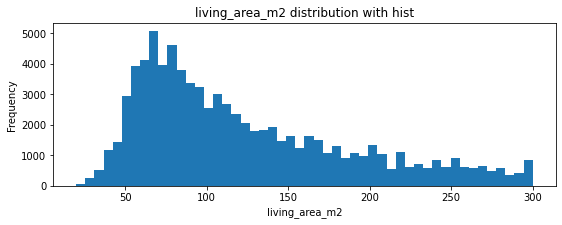

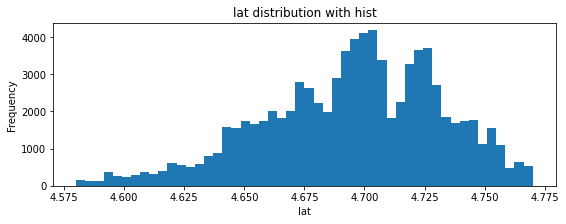

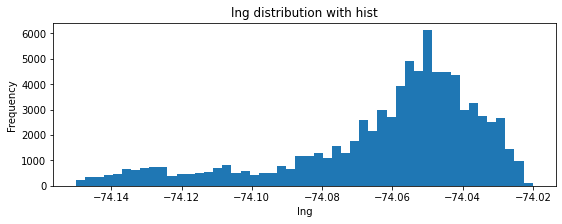

In [300]:
for i in ['price_m2', 'living_area_m2', 'lat', 'lng']:
    plt.figure(figsize = (9,3))
    plt.hist(data[i], bins = 100)
    plt.xlabel(i)
    plt.ylabel("Frequency")
    plt.title("{} distribution with hist".format(i))
    plt.show()

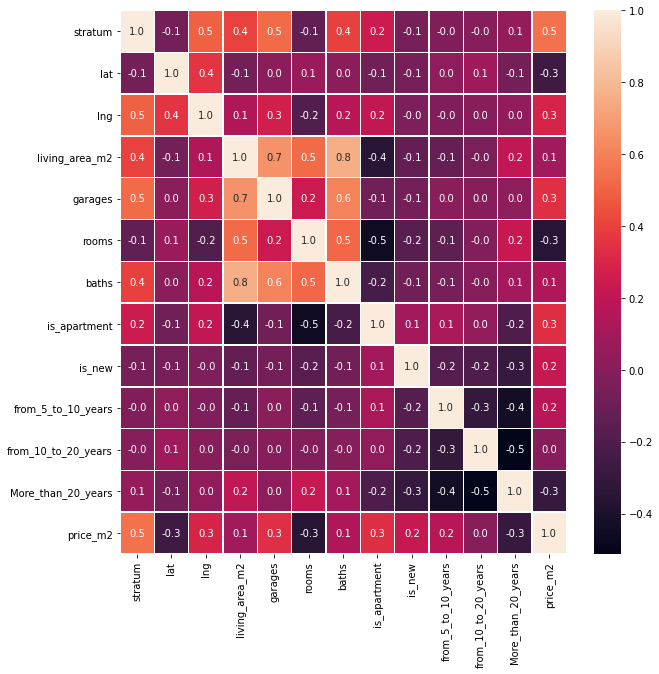

In [302]:
f,ax=plt.subplots(figsize=(10,10))
sns.heatmap(data[['stratum', 'lat', 'lng', 'living_area_m2', 'garages', 'rooms', 'baths', 'is_apartment', 'is_new', 'from_5_to_10_years', 'from_10_to_20_years', 'More_than_20_years', 'price_m2']].corr(),annot=True,linewidth=.5,fmt='.1f',ax=ax)
plt.show()

CPU times: user 7.64 s, sys: 2.53 s, total: 10.2 s
Wall time: 5.52 s


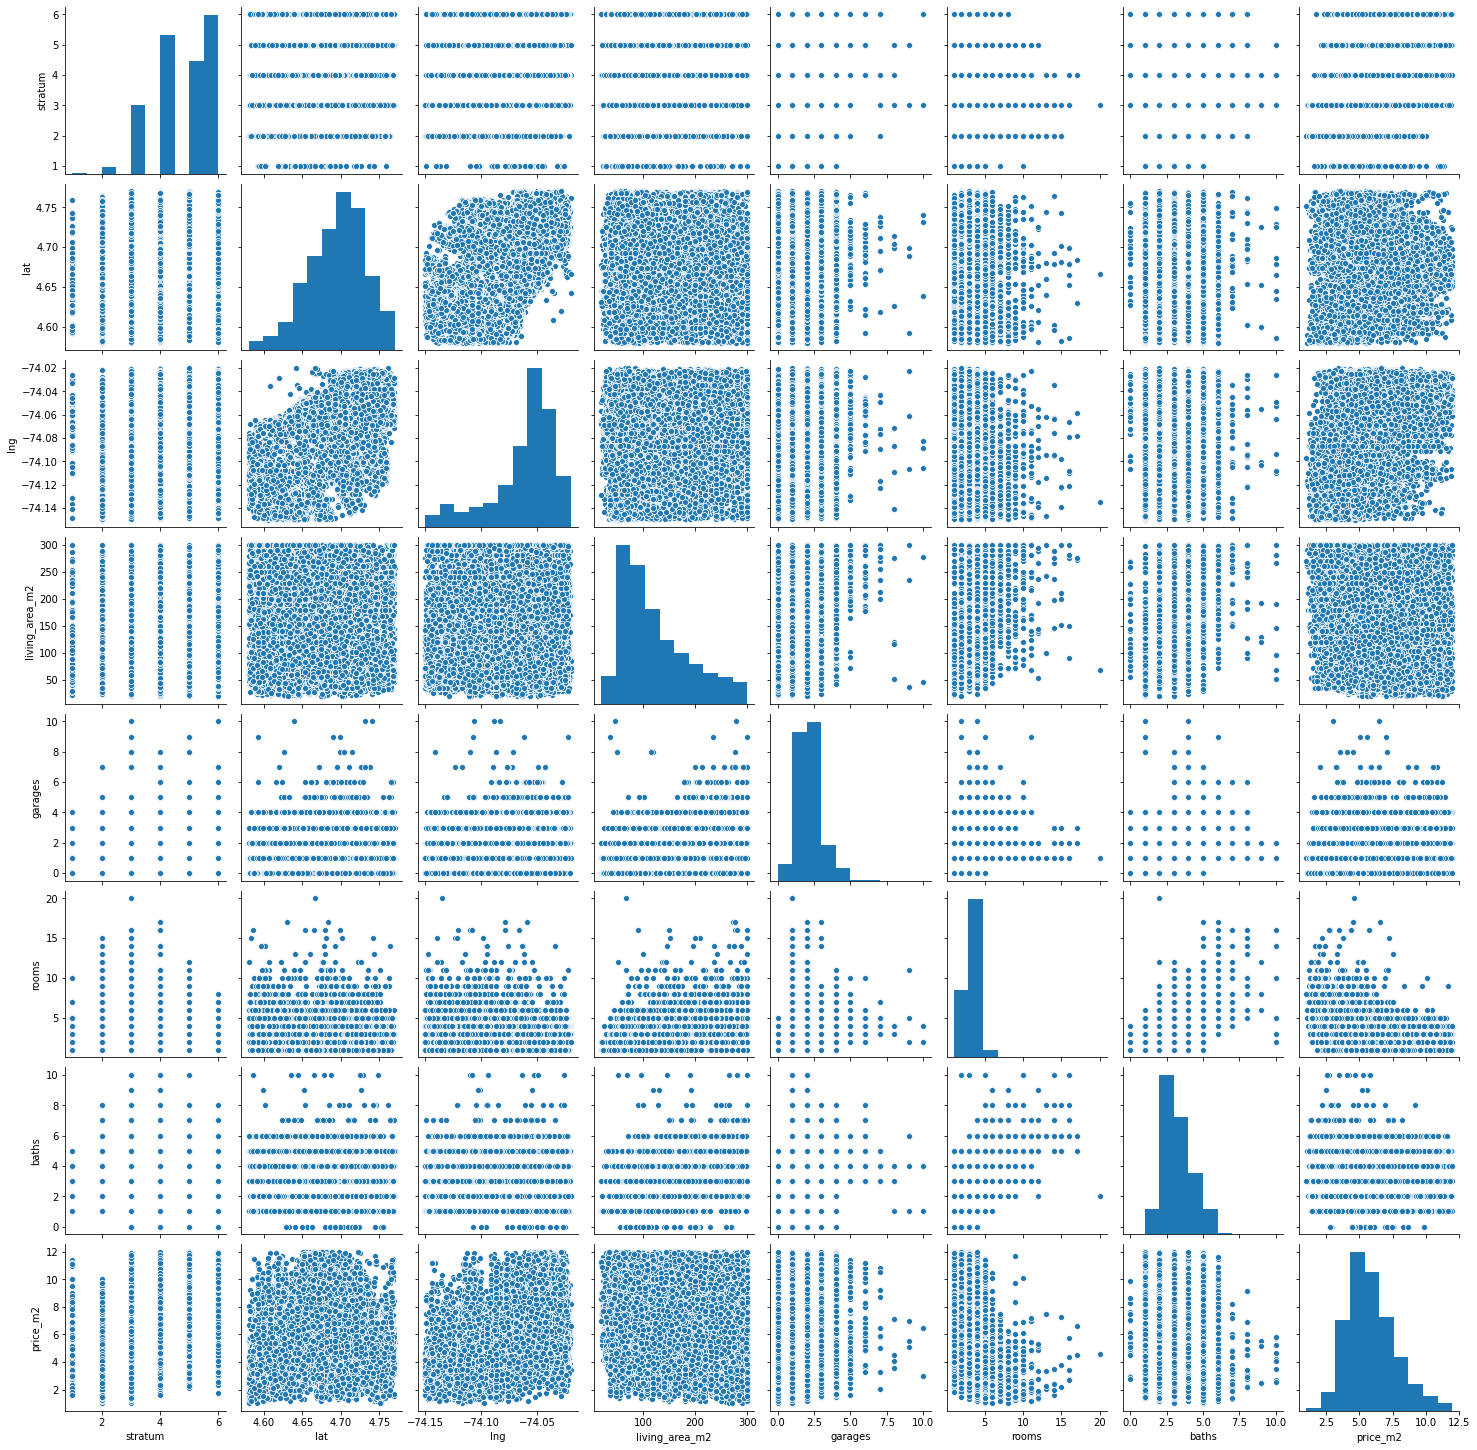

In [303]:
%time sns.pairplot(data[['stratum', 'lat', 'lng', 'living_area_m2', 'garages', 'rooms', 'baths', 'price_m2']], hue=None)

# Get neighborhoods

In [310]:
from shapely.geometry import shape, Point
import json

with open("Datos Abiertos - Bogota/Ordenamiento_Territorial - Sector_Catastral/Raw-data-sector-catastral-april-2023.geojson") as f:
    nbr_js = json.load(f)

def generate_polygon(feat):
    feat['poly'] = shape(feat["geometry"])
    return feat

def get_sector_name(prop):
    return prop['SCANOMBRE']

def get_nbr(row):
    point = Point(row['lng'], row['lat'])
    # res = df_sector_polygons[df_sector_polygons['poly'].contains(point)]
    res = df_sector_polygons['poly'].apply(lambda p : p.contains(point))
    if res[res].size > 0:
        index_found = res[res].index[0]
        return df_sector_polygons.iloc[[index_found]]['Sector_name'].values[0]
    else:
        return None
        
features = nbr_js['features']
sector_polygons = [generate_polygon(feat) for feat in features]
df_sector_polygons = pd.DataFrame.from_dict(sector_polygons)
df_sector_polygons['Sector_name'] = df_sector_polygons['properties'].map(lambda x:get_sector_name(x))
df_sector_polygons.drop(columns=['type', 'properties', 'geometry'], inplace=True)
        
%time main_df['nbr'] = main_df[['lng','lat']].apply(get_nbr,axis=1)
filter_df = main_df.dropna(subset=['nbr'])
print('After remove NaN in new nbr: ', len(filter_df.index))
display(filter_df.head())

CPU times: user 11min 12s, sys: 1.39 s, total: 11min 14s
Wall time: 11min 13s
After remove NaN in new nbr:  82437


,lat,lng,stratum,living_area_m2,administration_price,garages,rooms,baths,price_m2,is_apartment,from_10_to_20_years,from_5_to_10_years,More_than_20_years,is_new,nbr
0,4.672921,-74.050480,6.0,136.00,0.000,2.0,2.0,2.0,5.294118,True,False,False,False,True,EL CHICO
1,4.653309,-74.051476,6.0,117.51,0.840,2.0,2.0,2.0,9.537037,True,False,True,False,False,BELLAVISTA
2,4.668201,-74.046110,6.0,170.00,1.650,2.0,2.0,3.0,10.294118,True,False,True,False,False,LA CABRERA
4,4.687755,-74.054930,6.0,71.00,0.442,2.0,1.0,2.0,6.619718,True,False,False,False,True,SANTA BIBIANA
6,4.680287,-74.056046,6.0,57.00,0.254,1.0,1.0,2.0,7.672727,True,False,False,False,True,CHICO NORTE


In [311]:
print('Before remove NaN in new nbr: ', len(main_df.index))

Before remove NaN in new nbr:  82438


# Save to CSV

In [ ]:
.to_csv('Data/Raw_data_sales_full_incl_nbrs.csv', index=False)